# Scalability on Best-of-Traps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# import rpy2
%load_ext rpy2.ipython

C:\Program Files\Python310\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
library(ggplot2)
library(scales)
library(patchwork)

library(gt)
library(xtable)
library(dplyr)
library(tidyr)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




# Load data

In [3]:
# name_dict = {
#     "Kernel-GOMEA---Asymmetric": "Kernel GOMEA - Asymmetric",
#     "Kernel-GOMEA---Symmetric": "Kernel GOMEA - Symmetric",
# }
name_dict = {
    "DSMGA2": "DSMGA-II",
    "Kernel-GOMEA---Asymmetric": "LK-GOMEA (Asym)",
    "Kernel-GOMEA---Symmetric": "LK-GOMEA (Sym)",
}

In [4]:
res = pd.read_csv("./paper_singleobjective_e963b42_bot.csv.gz")
res["approach"] = res["approach"].replace(name_dict)
res

,#evaluations,time(ms),fitness,isKey,populationSize,solution,approach,run,l,fns
0,1,0,7.0,0,4,1100100000,DSMGA-II,23,10,2
1,11,1,8.0,0,4,1100100010,DSMGA-II,23,10,2
2,12,1,9.0,0,4,1101100010,DSMGA-II,23,10,2
3,119,1,10.0,1,8,0011110001,DSMGA-II,23,10,2
4,1,0,3.0,0,2,1001001000,LK-GOMEA (Asym),6,10,1
...,...,...,...,...,...,...,...,...,...,...
141272,46206,1082,316.0,0,64,1110000001011111110001111110100011000100001001...,DSMGA-II,20,320,1
141273,46307,1112,317.0,0,64,1110000001011111110001111110100011000000001001...,DSMGA-II,20,320,1
141274,46373,1118,318.0,0,64,1110000001011111110001111110100011000000011001...,DSMGA-II,20,320,1
141275,95258,1915,319.0,0,128,1110000001011110110001111010100011000000011001...,DSMGA-II,20,320,1


In [5]:
setting_columns = ["approach", "l", "fns"]
run_columns = setting_columns + ["run"]

# Scalability: #evaluations
How many evaluations does it take to get to the optimum?

In [14]:
# Derive the hitting point in #evaluations
def process_run(run_df):
    sorted_run_df = run_df.sort_values("#evaluations")
    potential_keypoint = sorted_run_df.iloc[-1]
    if potential_keypoint["isKey"]:
        return potential_keypoint["#evaluations"]
    else:
        return np.inf # ground truth - include
        # return np.nan # ground truth - leave out
        # return 100_000_000 # evaluation budget

hitting_evaluations = res.groupby(run_columns).apply(process_run).rename("hitting #evaluations").reset_index()

In [15]:
# Quick check if everything is finite (not the case if not all runs hit the optimum!)
def all_finite(df):
    return np.isfinite(df["hitting #evaluations"]).all()

hef = hitting_evaluations.groupby(setting_columns).apply(all_finite).rename("all runs finite").reset_index()
hitting_evaluations_af = pd.merge(hitting_evaluations, hef)
hitting_evaluations_af = hitting_evaluations_af[hitting_evaluations_af["all runs finite"]].copy()

In [16]:
# Compute statistics - replacing nan with inf
hitting_evaluations_q = hitting_evaluations.fillna(np.inf).groupby(setting_columns)["hitting #evaluations"].quantile([0.05, 0.5, 0.95]).unstack().fillna(np.inf).reset_index()
# hitting_evaluations_q.loc[~np.isfinite(hitting_evaluations_q[0.9]) & np.isfinite(hitting_evaluations_q[0.5]), 0.9] = max_evaluations
# Remove points where median is inf.
hitting_evaluations_q = hitting_evaluations_q[np.isfinite(hitting_evaluations_q[0.5])]
hitting_evaluations_q

,approach,l,fns,0.05,0.5,0.95
0,DSMGA-II,10,1,48.80,688.5,1555.45
1,DSMGA-II,10,2,27.00,377.5,1146.50
2,DSMGA-II,10,4,43.65,296.5,1866.90
3,DSMGA-II,10,8,9.15,83.0,308.50
4,DSMGA-II,20,1,716.25,1529.0,4946.75
...,...,...,...,...,...,...
91,LK-GOMEA (Sym),160,8,326238.30,353223.5,392704.10
92,LK-GOMEA (Sym),320,1,229714.60,238681.5,261271.00
93,LK-GOMEA (Sym),320,2,245126.55,266174.0,591979.00
94,LK-GOMEA (Sym),320,4,604393.00,632481.5,676514.20


R[write to console]: Saving 16.7 x 4.17 in image

R[write to console]: Saving 16.7 x 4.17 in image



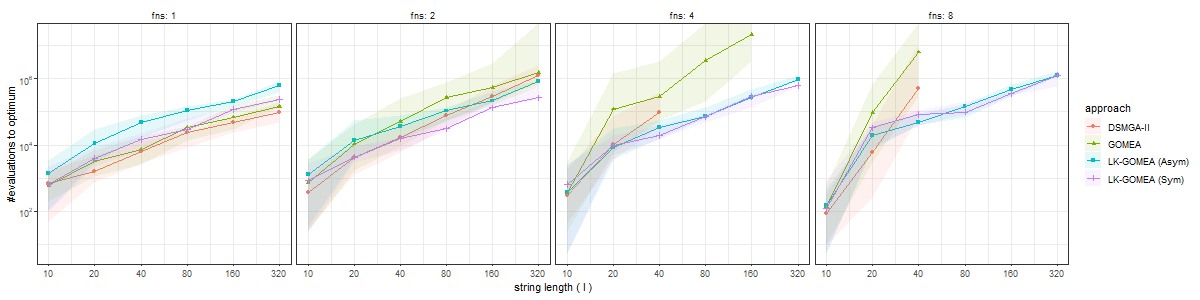

In [19]:
%%R -i hitting_evaluations_q -w 1200 -h 300
plt <- ggplot(hitting_evaluations_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) + 
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    #     labels=trans_format("log10", math_format(10^.x))) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
        labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_x_log10(
        breaks=unique(hitting_evaluations_q$l),
    ) +
    labs(x=expression("string length (" ~ l ~ ")"), y="#evaluations to optimum") +
    facet_grid(. ~ fns, labeller = label_both) +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA))
ggsave("./2021-12-23-paper_bot_scalability_evals.png")
ggsave("./2021-12-23-paper_bot_scalability_evals.pdf", device=cairo_pdf)
plt

# Scalability: Time
How much time does it take to get to the optimum?

In [20]:
# Derive the hitting point in #evaluations
def process_run(run_df):
    sorted_run_df = run_df.sort_values("time(ms)")
    potential_keypoint = sorted_run_df.iloc[-1]
    if potential_keypoint["isKey"]:
        return potential_keypoint["time(ms)"] + 1
    else:
        return np.nan

hitting_time = res.groupby(run_columns).apply(process_run).rename("hitting time (ms)").reset_index()

In [21]:
# Quick check if everything is finite (not the case if not all runs hit the optimum!)
def all_finite(df):
    return np.isfinite(df["hitting time (ms)"]).all()

hef = hitting_time.groupby(setting_columns).apply(all_finite).rename("all runs finite").reset_index()
hitting_time_af = pd.merge(hitting_time, hef)
hitting_time_af = hitting_time_af[hitting_time_af["all runs finite"]].copy()

In [22]:
# Compute statistics - replacing nan with inf
hitting_time_q = hitting_time.fillna(np.inf).groupby(setting_columns)["hitting time (ms)"].quantile([0.05, 0.5, 0.95]).unstack().fillna(np.inf).reset_index()
# hitting_time_q.loc[~np.isfinite(hitting_time_q[0.9]) & np.isfinite(hitting_time_q[0.5]), 0.9] = max_evaluations
# Remove points where median is inf.
hitting_time_q = hitting_time_q[np.isfinite(hitting_time_q[0.5])]
hitting_time_q

,approach,l,fns,0.05,0.5,0.95
0,DSMGA-II,10,1,1.00,2.0,2.00
1,DSMGA-II,10,2,1.00,2.0,2.55
2,DSMGA-II,10,4,1.00,1.5,3.00
3,DSMGA-II,10,8,1.00,1.0,2.00
4,DSMGA-II,20,1,2.00,2.5,10.75
...,...,...,...,...,...,...
91,LK-GOMEA (Sym),160,8,18837.65,21082.0,25232.90
92,LK-GOMEA (Sym),320,1,30311.90,34204.5,39261.80
93,LK-GOMEA (Sym),320,2,29982.15,35737.0,75785.70
94,LK-GOMEA (Sym),320,4,79350.35,85707.5,96358.95


R[write to console]: Saving 16.7 x 4.17 in image

R[write to console]: Saving 16.7 x 4.17 in image



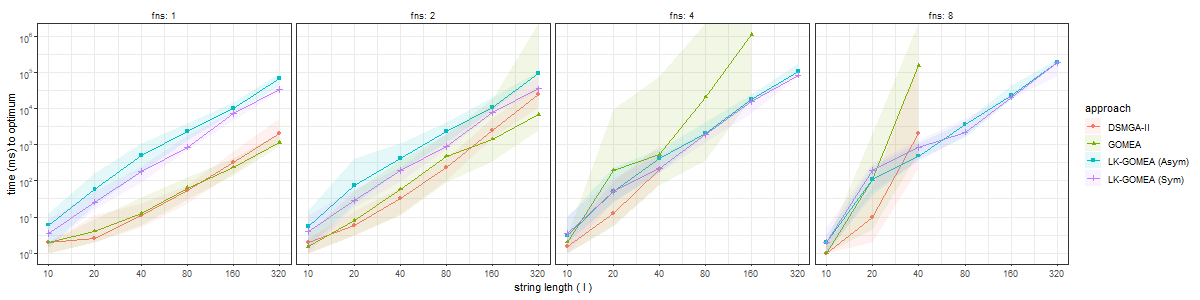

In [23]:
%%R -i hitting_time_q -w 1200 -h 300
plt <- ggplot(hitting_time_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) + 
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    #     labels=trans_format("log10", math_format(10^.x))) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
        labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_x_log10(
        breaks=unique(hitting_time_q$l),
    ) +
    labs(x=expression("string length (" ~ l ~ ")"), y="time (ms) to optimum") +
    facet_grid(. ~ fns, labeller = label_both) +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA))
    #theme(legend.position = "bottom")
ggsave("./2021-12-23-paper_bot_scalability_time.png")
ggsave("./2021-12-23-paper_bot_scalability_time.pdf", device=cairo_pdf)
plt

# Scalability: Population Size

In [24]:
# Derive the hitting point in #evaluations
def process_run(run_df):
    sorted_run_df = run_df.sort_values("#evaluations")
    potential_keypoint = sorted_run_df.iloc[-1]
    if potential_keypoint["isKey"]:
        return potential_keypoint["populationSize"]
    else:
        return np.inf # ground truth - include
        # return np.nan # ground truth - leave out
        # return 100_000_000 # evaluation budget

hitting_population_size = res.groupby(run_columns).apply(process_run).rename("hitting population size").reset_index()
hitting_population_size

,approach,l,fns,run,hitting population size
0,DSMGA-II,10,1,0,4.0
1,DSMGA-II,10,1,1,64.0
2,DSMGA-II,10,1,2,8.0
3,DSMGA-II,10,1,3,64.0
4,DSMGA-II,10,1,4,32.0
...,...,...,...,...,...
2875,LK-GOMEA (Sym),320,8,25,256.0
2876,LK-GOMEA (Sym),320,8,26,512.0
2877,LK-GOMEA (Sym),320,8,27,512.0
2878,LK-GOMEA (Sym),320,8,28,512.0


In [25]:
# Compute statistics - replacing nan with inf
hitting_population_size_q = hitting_population_size.fillna(np.inf).groupby(setting_columns)["hitting population size"].quantile([0.05, 0.5, 0.95]).unstack().fillna(np.inf).reset_index()
# hitting_population_size_q.loc[~np.isfinite(hitting_population_size_q[0.9]) & np.isfinite(hitting_population_size_q[0.5]), 0.9] = max_evaluations
# Remove points where median is inf.
hitting_population_size_q = hitting_population_size_q[np.isfinite(hitting_population_size_q[0.5])]
hitting_population_size_q

,approach,l,fns,0.05,0.5,0.95
0,DSMGA-II,10,1,5.8,32.0,64.0
1,DSMGA-II,10,2,4.0,16.0,49.6
2,DSMGA-II,10,4,4.0,16.0,64.0
3,DSMGA-II,10,8,4.0,8.0,16.0
4,DSMGA-II,20,1,16.0,32.0,64.0
...,...,...,...,...,...,...
91,LK-GOMEA (Sym),160,8,256.0,256.0,256.0
92,LK-GOMEA (Sym),320,1,128.0,128.0,128.0
93,LK-GOMEA (Sym),320,2,128.0,128.0,256.0
94,LK-GOMEA (Sym),320,4,256.0,256.0,256.0


R[write to console]: Saving 16.7 x 4.17 in image

R[write to console]: Saving 16.7 x 4.17 in image



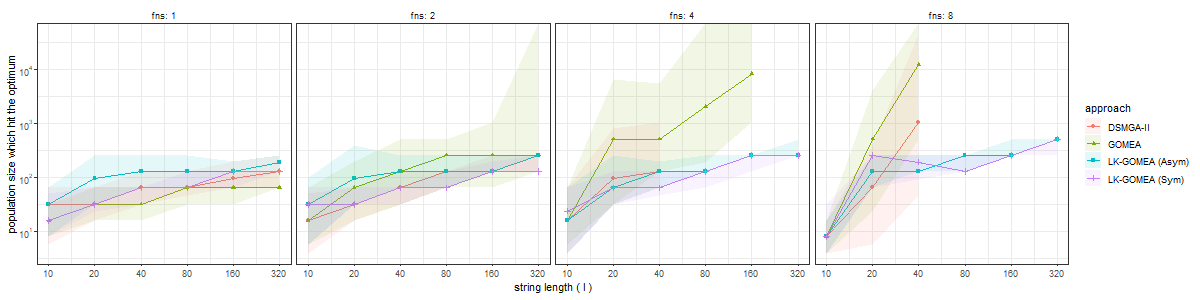

In [26]:
%%R -i hitting_population_size_q -w 1200 -h 300
plt <- ggplot(hitting_population_size_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) + 
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    #     labels=trans_format("log10", math_format(10^.x))) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
        labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_x_log10(
        breaks=unique(hitting_population_size_q$l),
    ) +
    labs(x=expression("string length (" ~ l ~ ")"), y="population size which hit the optimum") +
    facet_grid(. ~ fns, labeller = label_both) +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA))
    #theme(legend.position = "bottom")
ggsave("./2021-12-23-paper_bot_scalability_population_size.png")
ggsave("./2021-12-23-paper_bot_scalability_population_size.pdf", device=cairo_pdf)
plt

# Reliability
How often does the approach actually find the optimum?

In [27]:
def count_ratio_finite(df):
    return np.mean(np.isfinite(df))
ratio_success = hitting_evaluations.groupby(setting_columns)["hitting #evaluations"].apply(count_ratio_finite).rename("P(success)").reset_index()

ratio_success_style = ratio_success.pivot(["l", "fns"], "approach", "P(success)").style.background_gradient(cmap='gray', axis=1, vmin=0, vmax=1)
ratio_success_style

R[write to console]: Saving 16.7 x 4.17 in image

R[write to console]: Saving 16.7 x 4.17 in image



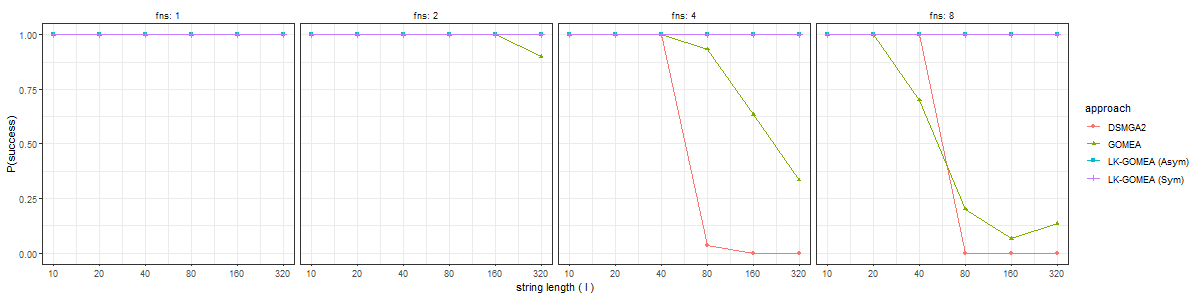

In [45]:
%%R -i ratio_success -w 1200 -h 300
plt <- ggplot(ratio_success, aes(x=`l`, y=`P(success)`, color=`approach`, shape=`approach`)) +
    geom_point() +
    geom_line() +
    ylim(0, 1) +
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    #     labels=trans_format("log10", math_format(10^.x))) +
    scale_x_log10(
        breaks=unique(ratio_success$l),
    ) +
    facet_grid(. ~ `fns`, labeller=label_both) +
    labs(x=expression("string length (" ~ l ~ ")")) +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA))
ggsave("./2021-12-23-paper_bot_reliability.png")
ggsave("./2021-12-23-paper_bot_reliability.pdf", device=cairo_pdf)
plt

# Multiple (merging!)

R[write to console]: Saving 16.7 x 5.56 in image

R[write to console]: Saving 16.7 x 5.56 in image



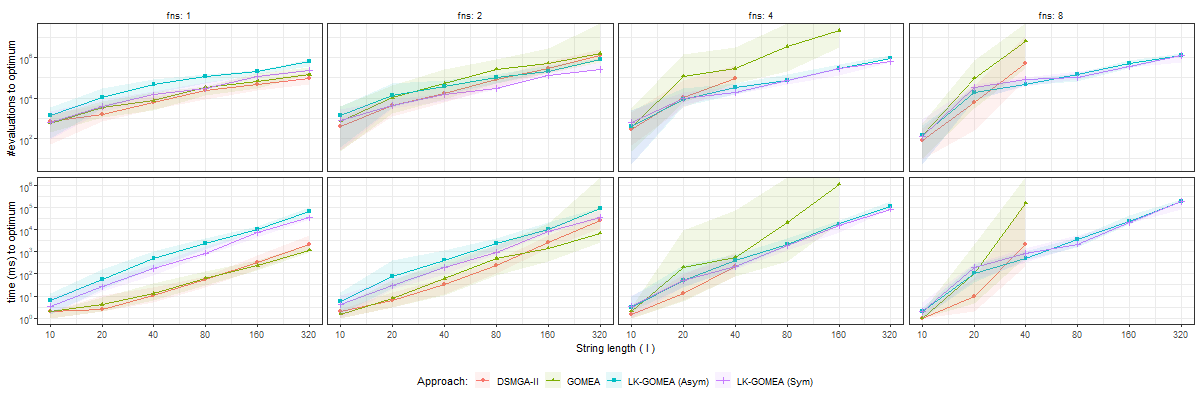

In [28]:
%%R -i hitting_evaluations_q -i hitting_time_q  -w 1200 -h 400

# Merging using patchwork, with hiding of the right aspects courtesy of https://stackoverflow.com/a/54586286

plt_e <- ggplot(hitting_evaluations_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) +
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    #     labels=trans_format("log10", math_format(10^.x))) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
        labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_x_log10(
        breaks=unique(hitting_evaluations_q$l),
    ) +
    labs(x=expression("String length (" ~ l ~ ")"), y="#evaluations to optimum", shape="Approach:", color="Approach:", fill="Approach:") +
    facet_grid(. ~ fns, labeller = label_both) +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA)) + theme(
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank()
    ) +
    theme(plot.margin = margin(b = 2, unit = "pt"))

plt_t <- ggplot(hitting_time_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) +
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    #     labels=trans_format("log10", math_format(10^.x))) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
        labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_x_log10(
        breaks=unique(hitting_time_q$l),
    ) +
    labs(x=expression("String length (" ~ l ~ ")"), y="time (ms) to optimum", shape="Approach:", color="Approach:", fill="Approach:") +
    facet_grid(. ~ fns, labeller = label_both) +
    theme_bw() +
theme(strip.text = element_blank()) +
theme(plot.margin = margin(t = 2, unit = "pt"))
    # theme(strip.background = element_rect(fill = NA, color=NA))

plt <- plt_e / plt_t + plot_layout(guides = "collect") & theme(legend.position = 'bottom')

ggsave("./2021-12-23-paper_bot_eval_and_time.png")
ggsave("./2021-12-23-paper_bot_eval_and_time.pdf", device=cairo_pdf)
plt

In [47]:
# hitting_merged_q = pd.merge(hitting_evaluations_q, hitting_time_q, on=["approach", "l", "fns"], suffixes=("_evaluations", "_time"))
# hitting_merged_q

In [48]:
subset = ["approach", "l", "fns", 0.5]
hitting_medians = pd.merge(hitting_evaluations_q[subset], hitting_time_q[subset], on=["approach", "l", "fns"], suffixes=("_evaluations", "_time"))
hitting_medians

,approach,l,fns,0.5_evaluations,0.5_time
0,DSMGA2,10,1,688.5,2.0
1,DSMGA2,10,2,377.5,2.0
2,DSMGA2,10,4,296.5,1.5
3,DSMGA2,10,8,83.0,1.0
4,DSMGA2,20,1,1529.0,2.5
...,...,...,...,...,...
81,LK-GOMEA (Sym),160,8,353223.5,21082.0
82,LK-GOMEA (Sym),320,1,238681.5,34204.5
83,LK-GOMEA (Sym),320,2,266174.0,35737.0
84,LK-GOMEA (Sym),320,4,632481.5,85707.5


In [73]:
%%R -i hitting_medians
tab <- hitting_medians %>%
    rename(`evaluations` = `0.5_evaluations`, `time (ms)`=`0.5_time`) %>%
    mutate(fns=paste("fns: ", fns)) %>%
    pivot_wider(names_from = approach, values_from=c(`evaluations`, `time (ms)`), names_sep= ".") %>%
    gt(groupname_col = "fns") %>%
    tab_header(title="Hitting evaluations & time for Best-of-Traps") %>%
    fmt_integer(starts_with("evaluations")) %>%
    tab_spanner_delim('.') %>%
    tab_footnote(footnote="", locations=cells_column_labels("time (ms).GOMEA")) %>%
    tab_style(style = cell_fill(color = "ghostwhite"), cells_body(columns=starts_with("time (ms)")))
    # data_color(starts_with("evaluations"), "white") %>%
    # data_color(starts_with("time (ms)"), "ghostwhite")

tab %>% gtsave("2021-12-23-paper_bot_table_evals_and_time_median.tex")
tab

# Statistical Significance
Our goal is to compare the scalability of the approaches, and as such compare the limiting behavior. We therefore perform all pairwise statistical tests for the highest value of $l$, and if applicable, for each value of $\mathit{fns}$. Due to the multiplicitity of comparisons we perform the Holm–Bonferroni* correction. A summary of the number of cases in which an approach is better (i.e. requires less time or evaluations) is provided in Table~[INSERT REFERENCE HERE], details and individual comparisons can be found in the supplementary material.

In [13]:
# For evaluations
l_max = hitting_evaluations["l"].max()
hitting_evaluations_l_max = hitting_evaluations[hitting_evaluations["l"] == l_max]
hitting_evaluations_l_max_by_approach = hitting_evaluations_l_max.groupby(setting_columns)["hitting #evaluations"].apply(list).reset_index()
a = 2 * 0.05 # 2 * as tests are correlated and corrected for count: one out of two tests is guaranteed to fail.

from scipy.stats import mannwhitneyu

# Create pairs
pairs_df = pd.merge(hitting_evaluations_l_max_by_approach, hitting_evaluations_l_max_by_approach, on="fns")
# Filter out same set of samples
pairs_df = pairs_df[pairs_df["approach_x"] != pairs_df['approach_y']]
def perform_test_on_pair(df):
    return mannwhitneyu(
         np.nan_to_num(df["hitting #evaluations_x"], nan=np.inf),
         np.nan_to_num(df["hitting #evaluations_y"], nan=np.inf),
         use_continuity = False, alternative="less")

pairs_df[["test statistic", "test p"]] = pairs_df.apply(perform_test_on_pair, axis=1).apply(pd.Series)

# Holm–Bonferroni
def perform_comparison(df):
    df = df.sort_values("test p")
    df["H0 accepted"] = (df["test p"] < a / (len(df) - np.arange(0, len(df)))).expanding().min()
    return df

pairs_df = pairs_df.groupby(["fns"]).apply(perform_comparison).reset_index(drop = True)

# Bonferroni (does the better correction actually impact the result?)
# pairs_df = pairs_df.sort_values("test p")
# pairs_df["H0 accepted"] = pairs_df["test p"] < a / len(pairs_df)
# Note to self: it does not.

signficant_evaluations = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "H0 accepted")
test_p_evaluations = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "test p")
# signficant_evals.to_latex("./2021-12-23-paper_bot_significant_evaluations.tex")
# signficant_evals

def styled(df):
    def get_style(m):
        if m is np.nan:
            return f"background-color: #d3d3d3; color: #000000;"
        if m:
            return f"background-color: #ffffff; color: #000000;"
        else:
            return f"background-color: #808080; color: #ffffff;"

    map_a = signficant_evaluations.applymap(get_style)
    map_a[np.isnan(df)] = f"background-color: #d3d3d3; color: #000000;"

    return map_a

test_p_evaluations_styled = test_p_evaluations.style.apply(styled, axis=None).format(na_rep="-", precision=3)
test_p_evaluations_styled.to_latex("./2021-12-23-paper_bot_significant_evaluations.tex", hrules=True, convert_css=True)
test_p_evaluations_styled

In [14]:
# For time
l_max = hitting_time["l"].max()
hitting_time_l_max = hitting_time[hitting_time["l"] == l_max]
hitting_time_l_max_by_approach = hitting_time_l_max.groupby(setting_columns)["hitting time (ms)"].apply(list).reset_index()
a = 0.05

from scipy.stats import mannwhitneyu

# Create pairs
pairs_df = pd.merge(hitting_time_l_max_by_approach, hitting_time_l_max_by_approach, on="fns")
# Filter out same set of samples
pairs_df = pairs_df[pairs_df["approach_x"] != pairs_df['approach_y']]
def perform_test_on_pair(df):
    return mannwhitneyu(
        np.nan_to_num(df["hitting time (ms)_x"], nan=np.inf),
        np.nan_to_num(df["hitting time (ms)_y"], nan=np.inf),
        use_continuity = False, alternative="less")

pairs_df[["test statistic", "test p"]] = pairs_df.apply(perform_test_on_pair, axis=1).apply(pd.Series)

# Holm–Bonferroni
def perform_comparison(df):
    df = df.sort_values("test p")
    df["H0 accepted"] = (df["test p"] < a / (len(df) - np.arange(0, len(df)))).expanding().min()
    return df

pairs_df = pairs_df.groupby(["fns"]).apply(perform_comparison).reset_index(drop = True)

# Bonferroni (does the better correction actually impact the result?)
# pairs_df = pairs_df.sort_values("test p")
# pairs_df["H0 accepted"] = pairs_df["test p"] < a / len(pairs_df)
# Note to self: it does not.

signficant_time = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "H0 accepted")
test_p_time = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "test p")
# signficant_time.to_latex("./2021-12-23-paper_bot_significant_time.tex")
# signficant_time


def styled(df):
    def get_style(m):
        if m is np.nan:
            return f"background-color: #d3d3d3; color: #000000;"
        if m:
            return f"background-color: #ffffff; color: #000000;"
        else:
            return f"background-color: #808080; color: #ffffff;"

    map_a = signficant_time.applymap(get_style)
    map_a[np.isnan(df)] = f"background-color: #d3d3d3; color: #000000;"

    return map_a

test_p_time_styled = test_p_time.style.apply(styled, axis=None).format(na_rep="-", precision=3)
test_p_time_styled.to_latex("./2021-12-23-paper_bot_significant_time.tex", hrules=True, convert_css=True)
test_p_time_styled

In [15]:
partial_sum_maxcut_evaluations = signficant_evaluations.stack().groupby("approach_x").sum()
partial_sum_maxcut_time = signficant_time.stack().groupby("approach_x").sum()
partial_sum_maxcut_evaluations.to_csv("counts_bot_evaluations.csv")
partial_sum_maxcut_time.to_csv("counts_bot_time.csv")
display(partial_sum_maxcut_evaluations)
display(partial_sum_maxcut_time)

approach_x
DSMGA2             3.0
GOMEA              3.0
LK-GOMEA (Asym)    6.0
LK-GOMEA (Sym)     9.0
dtype: float64

approach_x
DSMGA2             4.0
GOMEA              7.0
LK-GOMEA (Asym)    4.0
LK-GOMEA (Sym)     7.0
dtype: float64